In [1]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, img_ch, num_classes, image_size=32):
        super(Discriminator, self).__init__()
        self.img_ch = img_ch
        self.num_classes = num_classes
        self.image_size = image_size
        # input size: 1*32*32
        self.label_embedding = nn.Embedding(num_classes, self.image_size*self.image_size)
        
        self.discriminate = nn.Sequential(
            nn.Conv2d(img_ch+1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input, label):
        x_lbl = self.label_embedding(label)
        x_lbl = x_lbl.reshape([x_lbl.shape[0], 1, self.image_size, self.image_size])
        x = torch.cat((input, x_lbl), dim=1)
        x = self.discriminate(x)
        #print(x.shape)
        return x.squeeze()


class Generator(nn.Module):
    def __init__(self, in_channel, num_classes, img_ch):
        super(Generator, self).__init__()
        self.num_classes = num_classes
        label_embed_size = 5
        # input size: c*1*1
        self.label_embedding = nn.Embedding(num_classes, label_embed_size)

        self.generate = nn.Sequential(
            nn.ConvTranspose2d(in_channel+label_embed_size, 256, 4, 2, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_ch, 4, 2, 1, bias=False),
            nn.Tanh()
        )


  
    def forward(self, input, label):
        x_lbl = self.label_embedding(label)
        x_lbl = x_lbl.reshape([x_lbl.shape[0], -1, 1, 1])
        x = torch.cat((input, x_lbl), dim=1)
        return self.generate(x)


In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, FashionMNIST

class Network():
    def __init__(self, latent_dims=64, num_epochs=50, batch_size=256, learning_rate=2.0e-4, dataset='fashion_mnist', gpu=True):
        self.latent_dims = latent_dims
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.in_channel = 10
        self.dataset = dataset
        if dataset == 'mnist' or dataset == 'fashion_mnist':
            self.img_ch = 1
        else:
            self.img_ch = 3

        self.num_classes = 10
        self.learning_rate = learning_rate
        self.gpu = gpu
        self.dur_time = 0

        self._init_dataset()
        self._init_model()

    def _init_dataset(self):
        transform = transforms.Compose([
              transforms.Resize(32),
              transforms.ToTensor(), 
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        transform2 = transforms.Compose([
              transforms.Resize(32),
              transforms.ToTensor(), 
              transforms.Normalize((0.5,), (0.5,))
        ])

        if self.dataset == 'fashion_mnist':
            train_data = FashionMNIST(root='./dataset', download=True, train=True, transform=transform2)
            test_data = FashionMNIST(root='./dataset', download=True, train=False, transform=transform2)

        elif self.dataset == 'cifar10':
            train_data = CIFAR10(root='./dataset_cifar10', download=True, train=True, transform=transform)
            test_data = CIFAR10(root='./dataset_cifar10', download=True, train=False, transform=transform)

        self.train_queue = data.DataLoader(train_data, batch_size=self.batch_size, shuffle=True, drop_last=True)
        self.test_queue = data.DataLoader(test_data, batch_size=self.batch_size, shuffle=True, drop_last=True)

    def _weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def _init_model(self):
        self.device = torch.device('cuda' if (torch.cuda.is_available() & self.gpu) else 'cpu')

        Gen = Generator(self.in_channel, self.num_classes, self.img_ch).to(self.device)
        Dis = Discriminator(self.img_ch, self.num_classes).to(self.device)
        self.Gen = Gen.to(self.device)
        self.Dis = Dis.to(self.device)

        self.Gen.apply(self._weights_init)
        self.Dis.apply(self._weights_init)

        self.criterion = nn.BCELoss()

        #self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        self.G_optimizer = optim.Adam(self.Gen.parameters(), lr=self.learning_rate, betas=(0.5, 0.999), weight_decay=2e-5)    # optimizer
        self.D_optimizer = optim.Adam(self.Dis.parameters(), lr=self.learning_rate, betas=(0.5, 0.999), weight_decay=2e-5)

    def generate_imgs(self, z, fixed_label, epoch=0, num_images=20):
        samples_path = os.path.join('./samples1/Fashion')
        if not os.path.exists(samples_path):
            os.makedirs(samples_path)
            
        self.Gen.eval()
        fake_imgs = self.Gen(z, fixed_label)
        fake_imgs = (fake_imgs + 1) / 2
        fake_imgs_ = vutils.make_grid(fake_imgs, normalize=False, nrow=20)
        vutils.save_image(fake_imgs_, os.path.join(samples_path, 'sample_' + str(epoch) + '.png'))
        
        fake_imgs = fake_imgs.detach().cpu()
        for index, img in enumerate(fake_imgs):
            if index < num_images:
                #print(img.shape)
                plt.subplot(2, 10, index+1)
                plt.imshow(img.permute(1, 2, 0).squeeze(-1))
                plt.axis('off')

    def calc_time(self, seconds):
        m, s = divmod(seconds, 60)
        h, m = divmod(m, 60)
        t, h = divmod(h, 24)
        return {'day':t, 'hour':h, 'minute':m, 'second':int(s)}


    def train_fashion(self):
        G_loss_list = []
        D_loss_list = []
        run_start = time.time()

        self.Gen.train()
        self.Dis.train()
        for epoch in range(self.num_epochs):
            G_loss_sum = 0
            D_loss_sum = 0

            show_inputs = None
            show_outputs = None
            for step, (inputs, labels) in enumerate(self.train_queue):
                self.D_optimizer.zero_grad()

                inputs_real = inputs.to(self.device) # 64,1,32,32
                labels = labels.to(self.device)
                noise = torch.tensor(torch.randn(self.batch_size, self.in_channel, 1, 1, device=self.device)) # torch.Size([64, 100, 1, 1])
                
                # Generate fake data
                #x_fake = gen(z_fake, x_label)
                fake_out = self.Gen(noise, labels)
                
                real_label = torch.ones(self.batch_size,).to(self.device) # 64個1，代表真實的圖片
                fake_label = torch.zeros(self.batch_size,).to(self.device)   # 64個0，代表假的圖片
                
                # Train Discriminator
                fake_predict = self.Dis(fake_out.detach(), labels)
                inputs_real_predict = self.Dis(inputs_real.detach(), labels)
                D_loss = (self.criterion(fake_predict, fake_label) + self.criterion(inputs_real_predict, real_label)) / 2
                
                D_loss.backward()
                self.D_optimizer.step()

                D_loss_list.append(D_loss.item())
                D_loss_sum += D_loss

                self.G_optimizer.zero_grad()

                # 訓練生成真實圖片
                fake_predict2 = self.Dis(fake_out, labels)  # 獲得Discriminator的判斷
                G_loss = self.criterion(fake_predict2, real_label)
                
                G_loss_list.append(G_loss.item())
                G_loss_sum += G_loss
                G_loss.backward()
                self.G_optimizer.step()

                show_outputs = fake_out.detach().cpu()

            trainG_avg_loss = G_loss_sum/step
            trainD_avg_loss = D_loss_sum/step
            print('Epoch [{}]/[{}], D Loss:{}, G Loss:{}'.format(epoch, self.num_epochs, trainD_avg_loss, trainG_avg_loss))
            print('cost time: {}'.format(self.calc_time(self.dur_time + time.time() - run_start)))

            if epoch%5 == 0:
                #print(epoch)
                self.generate_imgs(noise, labels, epoch=epoch+1)
                plt.savefig('outputs_fashion_'+str(self.latent_dims)+'.png')
                plt.show()
                

        plt.subplot(211)
        plt.plot(G_loss_list)
        plt.subplot(212)
        plt.plot(D_loss_list)

        torch.save(self.Gen, './CGAN_Generator_fashion.pth')
        torch.save(self.Dis, './CGAN_Discriminator_fashion.pth')


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [0]/[50], D Loss:0.4833941161632538, G Loss:1.8949917554855347
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 1.0, 'second': 1}


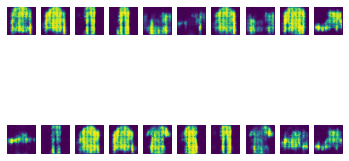

Epoch [1]/[50], D Loss:0.5775755643844604, G Loss:1.357606291770935
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 2.0, 'second': 3}
Epoch [2]/[50], D Loss:0.5910166501998901, G Loss:1.2502708435058594
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 3.0, 'second': 5}
Epoch [3]/[50], D Loss:0.6035730838775635, G Loss:1.198520541191101
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 4.0, 'second': 6}
Epoch [4]/[50], D Loss:0.5991673469543457, G Loss:1.201805830001831
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 5.0, 'second': 7}
Epoch [5]/[50], D Loss:0.6028084754943848, G Loss:1.1776227951049805
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 6.0, 'second': 8}


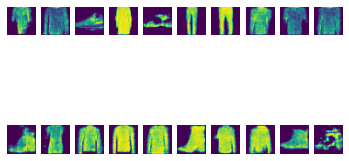

Epoch [6]/[50], D Loss:0.5916693210601807, G Loss:1.2103232145309448
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 7.0, 'second': 10}
Epoch [7]/[50], D Loss:0.5503203868865967, G Loss:1.3820079565048218
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 8.0, 'second': 12}
Epoch [8]/[50], D Loss:0.4935598373413086, G Loss:1.5176122188568115
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 9.0, 'second': 12}
Epoch [9]/[50], D Loss:0.4197719991207123, G Loss:1.7550947666168213
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 10.0, 'second': 14}
Epoch [10]/[50], D Loss:0.35797178745269775, G Loss:1.922345519065857
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 11.0, 'second': 15}


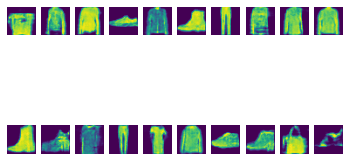

Epoch [11]/[50], D Loss:0.32298609614372253, G Loss:2.1569883823394775
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 12.0, 'second': 17}
Epoch [12]/[50], D Loss:0.27521517872810364, G Loss:2.350843906402588
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 13.0, 'second': 18}
Epoch [13]/[50], D Loss:0.29297134280204773, G Loss:2.3616833686828613
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 14.0, 'second': 19}
Epoch [14]/[50], D Loss:0.19184449315071106, G Loss:2.7385246753692627
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 15.0, 'second': 21}
Epoch [15]/[50], D Loss:0.25989004969596863, G Loss:2.5537991523742676
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 16.0, 'second': 22}


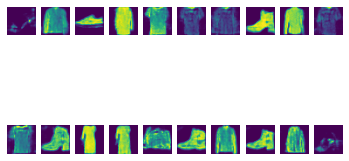

Epoch [16]/[50], D Loss:0.24696454405784607, G Loss:2.564631462097168
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 17.0, 'second': 24}
Epoch [17]/[50], D Loss:0.23105822503566742, G Loss:2.5843093395233154
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 18.0, 'second': 25}
Epoch [18]/[50], D Loss:0.21412715315818787, G Loss:2.834026336669922
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 19.0, 'second': 27}
Epoch [19]/[50], D Loss:0.21598032116889954, G Loss:2.8566393852233887
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 20.0, 'second': 29}
Epoch [20]/[50], D Loss:0.2582418918609619, G Loss:2.744823694229126
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 21.0, 'second': 31}


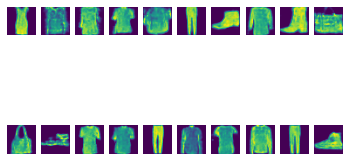

Epoch [21]/[50], D Loss:0.1475987434387207, G Loss:3.13808012008667
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 22.0, 'second': 34}
Epoch [22]/[50], D Loss:0.21624301373958588, G Loss:2.8079092502593994
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 23.0, 'second': 37}
Epoch [23]/[50], D Loss:0.2012738436460495, G Loss:2.970189094543457
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 24.0, 'second': 39}
Epoch [24]/[50], D Loss:0.167284294962883, G Loss:3.186717987060547
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 25.0, 'second': 42}
Epoch [25]/[50], D Loss:0.16160589456558228, G Loss:3.2401387691497803
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 26.0, 'second': 43}


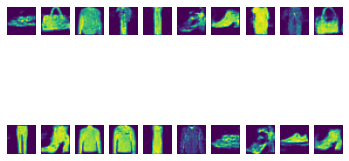

Epoch [26]/[50], D Loss:0.1947317123413086, G Loss:3.1708948612213135
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 27.0, 'second': 46}
Epoch [27]/[50], D Loss:0.23522524535655975, G Loss:2.8233325481414795
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 28.0, 'second': 47}
Epoch [28]/[50], D Loss:0.15853886306285858, G Loss:3.2032816410064697
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 29.0, 'second': 49}
Epoch [29]/[50], D Loss:0.17063365876674652, G Loss:3.3726141452789307
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 30.0, 'second': 50}
Epoch [30]/[50], D Loss:0.24252119660377502, G Loss:2.87900710105896
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 31.0, 'second': 51}


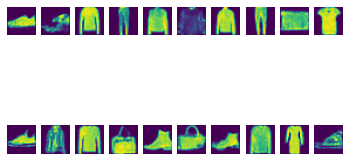

Epoch [31]/[50], D Loss:0.19847100973129272, G Loss:3.1928398609161377
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 32.0, 'second': 53}
Epoch [32]/[50], D Loss:0.16001228988170624, G Loss:3.367030143737793
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 33.0, 'second': 54}
Epoch [33]/[50], D Loss:0.16105900704860687, G Loss:3.4491450786590576
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 34.0, 'second': 55}
Epoch [34]/[50], D Loss:0.16348853707313538, G Loss:3.4197278022766113
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 35.0, 'second': 56}
Epoch [35]/[50], D Loss:0.1875910758972168, G Loss:3.3917949199676514
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 36.0, 'second': 57}


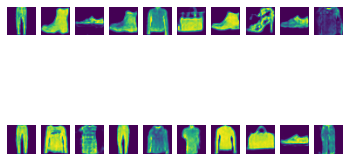

Epoch [36]/[50], D Loss:0.17772729694843292, G Loss:3.302508592605591
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 37.0, 'second': 58}
Epoch [37]/[50], D Loss:0.1956634521484375, G Loss:3.2370688915252686
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 38.0, 'second': 59}
Epoch [38]/[50], D Loss:0.24183744192123413, G Loss:3.074397563934326
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 39.0, 'second': 59}
Epoch [39]/[50], D Loss:0.1164783239364624, G Loss:3.658473014831543
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 41.0, 'second': 0}
Epoch [40]/[50], D Loss:0.10214567929506302, G Loss:4.2776618003845215
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 42.0, 'second': 1}


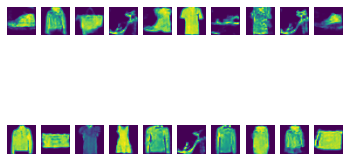

Epoch [41]/[50], D Loss:0.16020676493644714, G Loss:3.5989396572113037
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 43.0, 'second': 3}
Epoch [42]/[50], D Loss:0.17901960015296936, G Loss:3.287997245788574
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 44.0, 'second': 4}
Epoch [43]/[50], D Loss:0.15949557721614838, G Loss:3.557945489883423
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 45.0, 'second': 5}
Epoch [44]/[50], D Loss:0.14236901700496674, G Loss:4.085953712463379
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 46.0, 'second': 5}
Epoch [45]/[50], D Loss:0.11741502583026886, G Loss:3.465353012084961
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 47.0, 'second': 6}


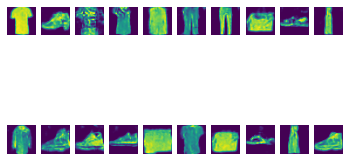

Epoch [46]/[50], D Loss:0.12753435969352722, G Loss:3.84082293510437
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 48.0, 'second': 8}
Epoch [47]/[50], D Loss:0.21485626697540283, G Loss:2.9643001556396484
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 49.0, 'second': 9}
Epoch [48]/[50], D Loss:0.14653410017490387, G Loss:3.6096646785736084
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 50.0, 'second': 9}
Epoch [49]/[50], D Loss:0.18357732892036438, G Loss:3.285820722579956
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 51.0, 'second': 10}


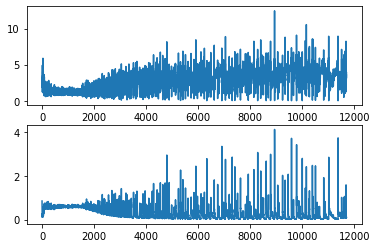

In [3]:
# Training latent dimension = 64 
if __name__ == '__main__':
    train_network = Network()
    train_network.train_fashion()